# Fetch log analysis

Exploratory analysis of the stop times fetching log data.

## Setup

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import requests

%matplotlib notebook

Read the data to a pandas DataFrame and show the first rows. Also convert some  columns.

In [2]:
df = pd.read_csv('fetch_log', parse_dates=['actual_date'], index_col='actual_date')
#df['actual_date'] = pd.to_datetime(df['actual_date'])
#df = df.set_index('actual_date')
df['resp_length'] = pd.to_numeric(df['resp_length'], errors='coerce')
#df = df['2020-02-12 00:00':]
df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cod_stop,resp_time,resp_status,resp_length,timeout,connection_error,max_connections,timeout_time
actual_date,,,,,,,,
2020-02-08 10:33:34.057465,8_18927,2.229505,200,3984.0,False,NaN,NaN,NaN
2020-02-08 10:33:34.054500,8_09375,2.394214,200,3875.0,False,NaN,NaN,NaN
2020-02-08 10:33:34.055216,8_13205,2.394226,200,2094.0,False,NaN,NaN,NaN
2020-02-08 10:33:34.053854,8_09490,2.396440,200,2089.0,False,NaN,NaN,NaN
2020-02-08 10:33:34.056932,8_08704,2.409032,200,3824.0,False,NaN,NaN,NaN


In [3]:
print('Data from ' + str(df.index.values.min()) + ' to ' + str(df.index.values.max()) +'.')

Data from 2020-02-08T10:33:34.038150000 to 2020-02-15T01:10:56.470492000.


## Histogram of response time depending on the status code

If a timeout ocurred, the status code is set to None.

<IPython.core.display.Javascript object>


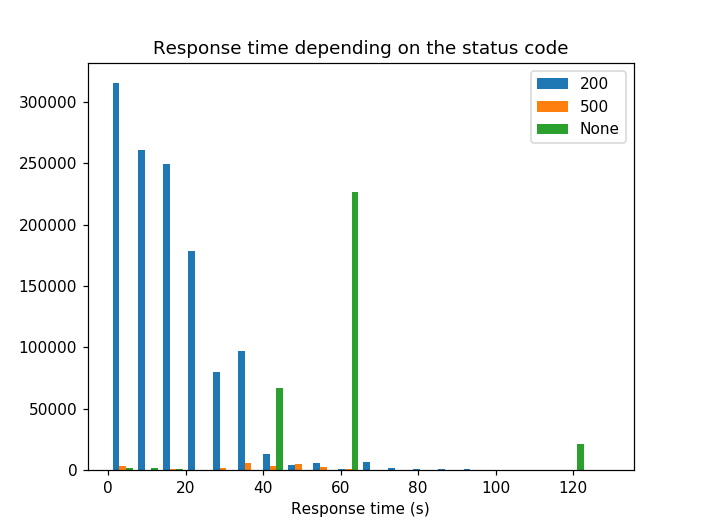

In [4]:
error_codes = df['resp_status'].unique()
plt.figure()
plt.title('Response time depending on the status code')
plt.xlabel('Response time (s)')
plt.hist([df.query("resp_time < 150").loc[df['resp_status'] == x, 'resp_time'] for x in error_codes], label=error_codes, bins=20)
plt.legend(error_codes)
plt.show()

### Summary of the response time depending on the status code

In [5]:
print(df.query("resp_status == '200'")['resp_time'].describe())

count    1.215189e+06
mean     1.628747e+01
std      1.187988e+01
min      5.624110e-01
25%      6.687495e+00
50%      1.433582e+01
75%      2.265694e+01
max      1.086576e+02
Name: resp_time, dtype: float64


In [6]:
print(df.query("resp_status == '500'")['resp_time'].describe())

count    22400.000000
mean        37.750603
std         19.788487
min          0.495882
25%         32.227170
50%         39.315418
75%         48.222866
max        118.284525
Name: resp_time, dtype: float64


## Average response time per stop

### Histogram

<IPython.core.display.Javascript object>


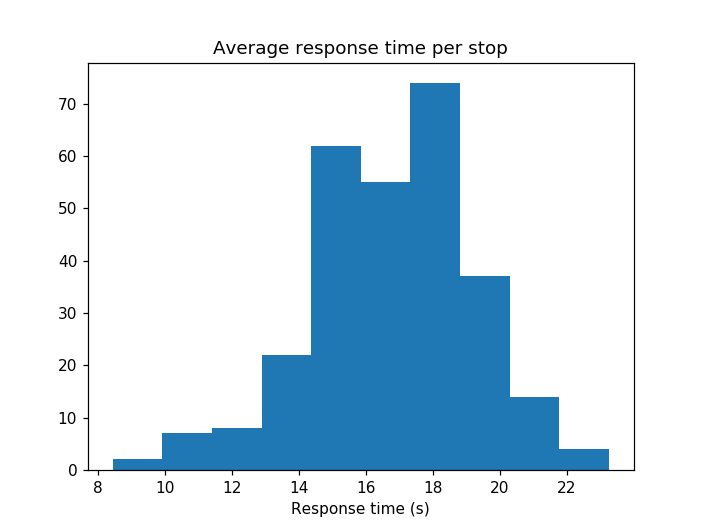

In [7]:
df_grouped = df.query("timeout == False").groupby('cod_stop')['resp_time'].mean()
plt.figure()
plt.title('Average response time per stop')
plt.xlabel('Response time (s)')
plt.hist(df_grouped)
plt.show()

In [8]:
df_grouped.describe()

count    285.000000
mean      16.770149
std        2.415301
min        8.435842
25%       15.321777
50%       16.874148
75%       18.480279
max       23.256491
Name: resp_time, dtype: float64

### Boxplot of response time per stop

In [9]:
# Really slow
#df.boxplot(column='resp_time', by='cod_stop')

In [10]:
# Sorted by mean DO NOT RUN (needs a lot of RAM)
#grouped = df.groupby('cod_stop')
#
#df2 = pd.DataFrame({col:vals['resp_time'] for col,vals in grouped})
#
#meds = df2.mean()
#meds.sort(ascending=False)
#df2 = df2[meds.index]
#df2.boxplot(column='resp_time', by='cod_stop')

### Over number of different lines of each stop

In [11]:
file_path = 'm8_Estaciones.json'

if not os.path.exists(file_path):
  url = 'https://opendata.arcgis.com/datasets/19884a02ac044270b91fa478d80f7858_0.csv?outSR=%7B%22latestWkid%22%3A25830%2C%22wkid%22%3A25830%7D'
  r = requests.get(url)
  with open(file_path, 'w') as f:
    f.write(r.content.decode("utf-8"))

with open(file_path, 'r') as f:
  est = pd.read_csv(f)

In [12]:
def get_nlines(row):
    """Returns the number of different lines that a stop has.
    
    Keyword arguments:
    row -- must have a row['cod_stop'] attribute with the stop code
    """
    return len(est.query("IDESTACION == '{cod_stop}'".format(cod_stop=row['cod_stop']))['LINEAS'].iloc[0].split(', '))

In [13]:
df_grouped_nlines = df_grouped.reset_index(name='mean_resp_time')
df_grouped_nlines['nlines'] = df_grouped_nlines.apply(get_nlines, axis=1)

<IPython.core.display.Javascript object>


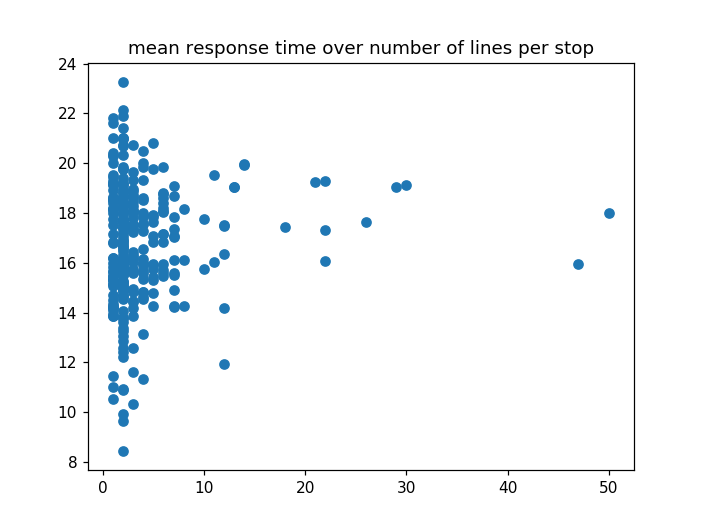

In [14]:
plt.figure()
plt.title('mean response time over number of lines per stop')
plt.scatter(x=df_grouped_nlines['nlines'], y=df_grouped_nlines['mean_resp_time'])
plt.show()

## Histogram of the response lenght depending on the status code

<IPython.core.display.Javascript object>


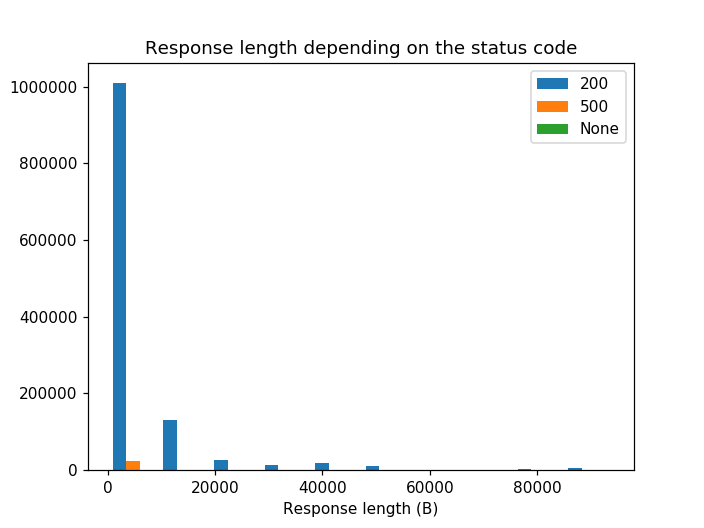

/opt/conda/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6743: RuntimeWarning: All-NaN axis encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/conda/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6744: RuntimeWarning: All-NaN axis encountered
  xmax = max(xmax, np.nanmax(xi))


In [15]:
plt.figure()
plt.title('Response length depending on the status code')
plt.xlabel('Response length (B)')
error_codes = df['resp_status'].unique()
plt.hist([df.loc[df['resp_status'] == x, 'resp_length'] for x in error_codes], label=error_codes)
plt.legend(error_codes)
plt.show()

### Summary of the response length for requests that returned status 500

In [16]:
print(df.query("resp_status == '500'")['resp_length'].describe())

count    22400.000000
mean       138.924375
std        158.650883
min          0.000000
25%          0.000000
50%         80.000000
75%        299.000000
max        433.000000
Name: resp_length, dtype: float64


### Summary of the response length for requests that returned status 200

In [17]:
print(df.query("resp_status == '200'")['resp_length'].describe())

count    1.215189e+06
mean     6.707635e+03
std      1.032609e+04
min      2.790000e+02
25%      2.087000e+03
50%      3.889000e+03
75%      7.373000e+03
max      9.427900e+04
Name: resp_length, dtype: float64


## Histogram of response time of requests that had an empty answer

<IPython.core.display.Javascript object>


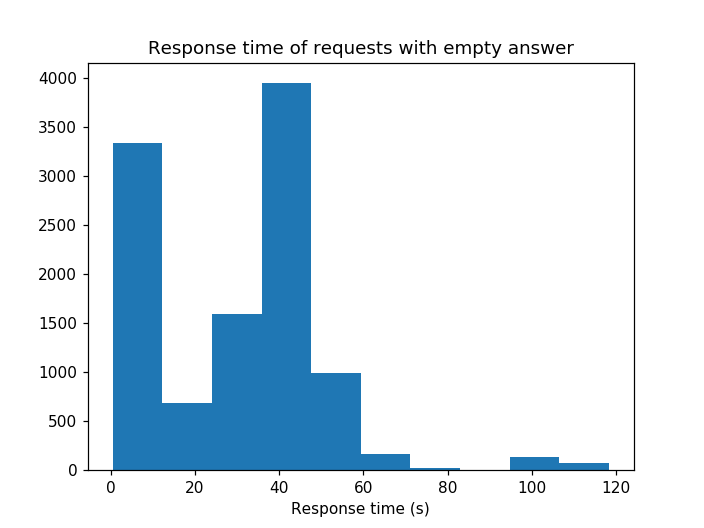

In [18]:
plt.figure()
plt.title('Response time of requests with empty answer')
plt.xlabel('Response time (s)')
plt.hist(df.query("resp_length == 0 & timeout == False")['resp_time'])
plt.show()

In [19]:
df.query("resp_length == 0").describe()

,resp_time,resp_length,max_connections,timeout_time
count,10928.000000,10928.0,2.0,2.0
mean,28.705016,0.0,70.0,60.0
std,21.618432,0.0,0.0,0.0
min,0.495882,0.0,70.0,60.0
25%,3.566381,0.0,70.0,60.0
50%,35.394235,0.0,70.0,60.0
75%,41.995976,0.0,70.0,60.0
max,118.284525,0.0,70.0,60.0


## Timeouts over time

<IPython.core.display.Javascript object>


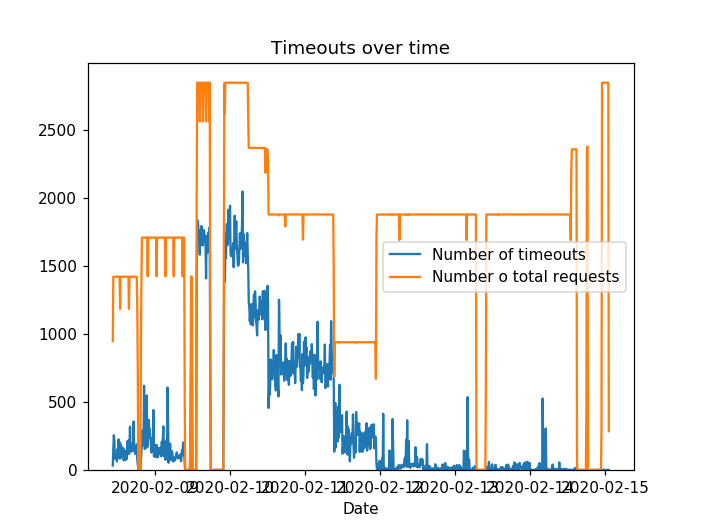

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [20]:
minute_mean_sum = df.resample("10Min").sum()
minute_mean_count = df.resample("10Min").count()
plt.figure()
plt.title('Timeouts over time')
plt.xlabel('Date')
plt.plot(minute_mean_sum['timeout'])
plt.plot(minute_mean_count['timeout'])
plt.ylim(bottom=0)
plt.legend(['Number of timeouts', 'Number o total requests'])
plt.show()

In [21]:
minute_mean_sum.head()

,resp_time,resp_length,timeout,max_connections,timeout_time
actual_date,,,,,
2020-02-08 10:30:00,14571.295213,7149990.0,32.0,0.0,0.0
2020-02-08 10:40:00,27837.425117,9898476.0,157.0,0.0,0.0
2020-02-08 10:50:00,27930.575281,9268630.0,255.0,0.0,0.0
2020-02-08 11:00:00,29236.111084,9466395.0,219.0,0.0,0.0
2020-02-08 11:10:00,24611.163975,10490873.0,93.0,0.0,0.0


In [22]:
minute_mean_count.head()

,cod_stop,resp_time,resp_status,resp_length,timeout,connection_error,max_connections,timeout_time
actual_date,,,,,,,,
2020-02-08 10:30:00,948,948,948,916,948,0,0,0
2020-02-08 10:40:00,1422,1422,1422,1265,1422,0,0,0
2020-02-08 10:50:00,1422,1422,1422,1167,1422,0,0,0
2020-02-08 11:00:00,1422,1422,1422,1203,1422,0,0,0
2020-02-08 11:10:00,1422,1422,1422,1329,1422,0,0,0


## Response time over time

<IPython.core.display.Javascript object>


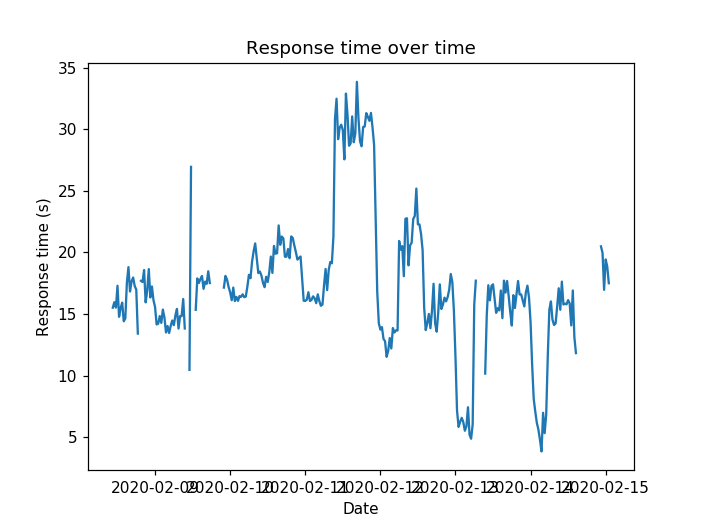

In [23]:
minute_mean = df.query("resp_length > 0 & resp_status == '200' & timeout == False").resample("30Min").mean()
plt.figure()
plt.title('Response time over time')
plt.xlabel('Date')
plt.ylabel('Response time (s)')
plt.plot(minute_mean['resp_time'])
#plt.hist([df.loc[df['resp_status'] == x, 'actual_date'] for x in error_codes], label=error_codes)
plt.show()

## Response size over time

<IPython.core.display.Javascript object>


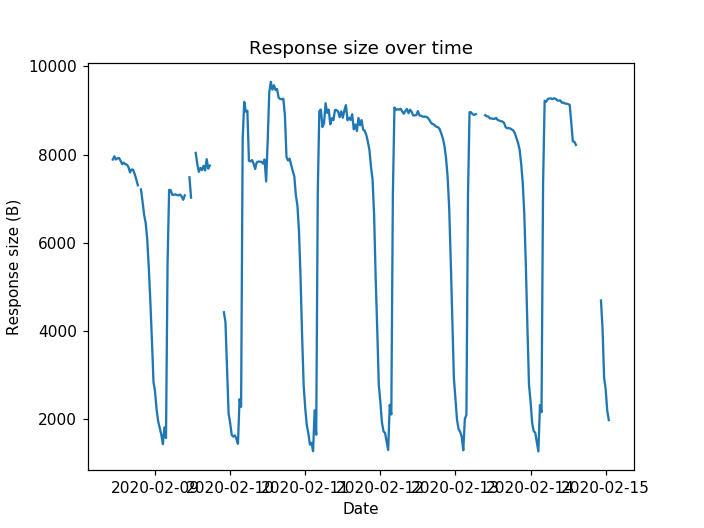

In [24]:
minute_mean = df.query("resp_length > 0 & resp_status == '200' & timeout == False").resample("30Min").mean()
plt.figure()
plt.title('Response size over time')
plt.xlabel('Date')
plt.ylabel('Response size (B)')
plt.plot(minute_mean['resp_length'])
plt.show()

## Response status over time

<IPython.core.display.Javascript object>


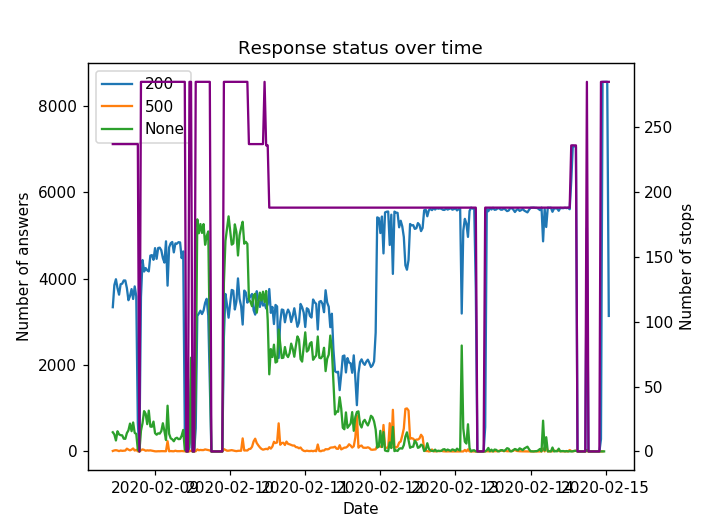

In [25]:
plt.figure()
plt.title('Response status over time')
plt.xlabel('Date')
status_codes = df['resp_status'].unique()
for status_code in status_codes:
    plt.plot(df.query("resp_status == '{status_code}'".format(status_code=status_code)).resample("30Min").count()['resp_status'], label=status_code)
plt.ylabel('Number of answers')
plt.legend()
plt.twinx()
plt.plot(df['cod_stop'].resample("30Min").nunique(), color='purple')
plt.ylabel('Number of stops')
plt.show()

## Percent of timeouts per stop

<IPython.core.display.Javascript object>


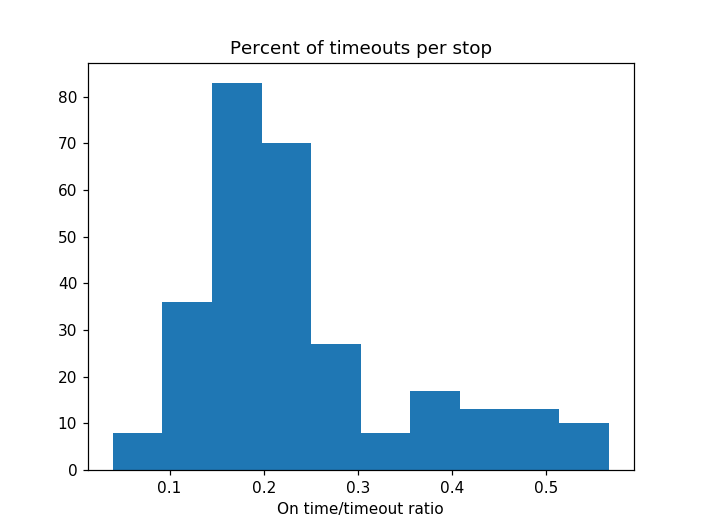

    cod_stop  timeout     ratio
1    8_06002     True  0.192219
3    8_06003     True  0.180968
5    8_06012     True  0.168270
7    8_06015     True  0.471317
9    8_06029     True  0.146883
..       ...      ...       ...
561   8_4795     True  0.205934
563  8_50001     True  0.127036
565  8_50018     True  0.176375
567  8_50019     True  0.213201
569   8_5598     True  0.147154

[285 rows x 3 columns]


,ratio
count,285.000000
mean,0.240340
std,0.115451
min,0.039688
25%,0.163279
50%,0.207831
75%,0.268501
max,0.566210


In [26]:
plt.figure()
plt.title('Percent of timeouts per stop')
plt.xlabel('On time/timeout ratio')
timeout_ratio = df.groupby(['cod_stop'])['timeout'].value_counts(normalize=True).reset_index(name='ratio').query("timeout == True")
plt.hist(timeout_ratio['ratio'])
print(timeout_ratio)
timeout_ratio.describe()

In [27]:
df.groupby(['cod_stop'])['timeout'].value_counts(normalize=True).reset_index(name='ratio').query("timeout == True").sort_values(by='ratio')

,cod_stop,timeout,ratio
267,8_09481,True,0.039688
421,8_16793,True,0.065104
359,8_11670,True,0.068449
95,8_06882,True,0.078176
489,8_18928,True,0.081008
...,...,...,...
274,8_09489,True,0.532865
64,8_06446,True,0.533601
272,8_09485,True,0.534247
474,8_17965,True,0.546914


In [28]:
df.groupby(['cod_stop']).count().sort_values(by='resp_time')

,resp_time,resp_status,resp_length,timeout,connection_error,max_connections,timeout_time
cod_stop,,,,,,,
8_09494,1533,1533,788,1533,773,153,153
8_09482,1533,1533,1030,1533,773,153,153
8_09485,1533,1533,714,1533,773,153,153
8_06508,1533,1533,719,1533,773,153,153
8_10856,1533,1533,665,1533,773,153,153
...,...,...,...,...,...,...,...
8_09047,7384,7384,6622,7384,6325,153,153
8_06280,7384,7384,6698,7384,6327,153,153
8_20325,7385,7385,6549,7385,6326,153,153


In [29]:
df.query("cod_stop == '8_09345' & timeout == False")['resp_time'].describe()

count    5884.000000
mean       18.670516
std        12.600312
min         0.562342
25%         6.691229
50%        18.057980
75%        26.603358
max        87.806013
Name: resp_time, dtype: float64

In [30]:
df['timeout'].value_counts(normalize=True)

False    0.795965
True     0.204035
Name: timeout, dtype: float64

## Timeout ratio over time

<IPython.core.display.Javascript object>


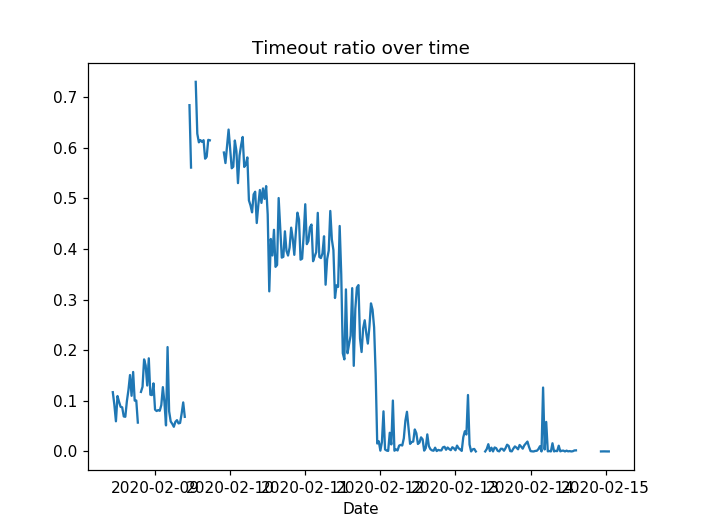

In [31]:
plt.figure()
plt.title('Timeout ratio over time')
plt.xlabel('Date')
timeout_sampled = df['timeout'].resample("30Min")
timeout_ratio_sampled = timeout_sampled.sum()/timeout_sampled.count()
plt.plot(timeout_ratio_sampled)
plt.show()